# KNN for Groundwater Quality Classification

This notebook runs a complete K-Nearest Neighbors (KNN) pipeline on the groundwater dataset. It includes EDA, preprocessing, model training, cross-validation and hyperparameter tuning.

**Notes:**
- Target column: `quality_class`.
- The notebook attempts to load the dataset from the Windows path you provided. If not found, it will try `/mnt/data/groundwater_cleaned_imputed.csv` (useful if you uploaded the file to the notebook environment).


In [1]:
# Imports
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, classification_report, RocCurveDisplay, precision_recall_curve, auc, roc_curve)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib

print('Libraries loaded')

Libraries loaded


In [2]:
# Load dataset (tries user path first, then fallback)
user_path = os.path.join("..", "data", "groundwater_cleaned_imputed.csv")
fallback = "/mnt/data/groundwater_cleaned_imputed.csv" 

if os.path.exists(user_path):
    data_path = user_path
elif os.path.exists(fallback):
    data_path = fallback
else:
    raise FileNotFoundError(f"Dataset not found. Tried:\n  {user_path}\n  {fallback}")

df = pd.read_csv(data_path)
print("Loaded:", data_path)
print("Shape:", df.shape)
df.head()

Loaded: ..\data\groundwater_cleaned_imputed.csv
Shape: (16737, 29)


,s_no,state,district,location,longitude,latitude,year,ph,ec_s_cm_at,co3_mg_l,...,na_mg_l,k_mg_l,fe_ppm,as_ppb,u_ppb,po4_missing_flag,fe_ppm_missing_flag,as_ppb_missing_flag,u_ppb_missing_flag,quality_class
0,1,Andaman & Nicobar Islands,North & Middle Andaman,Bakultala,92.8577,12.5043,2023,7.96,395.0,0.0,...,18.0,5.0,0.53,0.22,1.66,0,0,1,1,1
1,2,Andaman & Nicobar Islands,North & Middle Andaman,Baratang (Nilambur),92.7670,12.1683,2023,8.19,473.0,0.0,...,39.0,5.0,0.00,0.22,1.66,0,0,1,1,0
2,3,Andaman & Nicobar Islands,North & Middle Andaman,Basantipur,92.8737,12.7579,2023,8.19,556.0,0.0,...,22.0,1.0,0.22,0.22,1.66,0,0,1,1,0
3,4,Andaman & Nicobar Islands,North & Middle Andaman,Betapur,92.9434,12.6191,2023,8.07,487.0,0.0,...,68.0,8.0,0.04,0.22,1.66,0,0,1,1,0
4,5,Andaman & Nicobar Islands,North & Middle Andaman,Dhobidera (Mayabunder),92.8992,12.9099,2023,8.02,567.0,0.0,...,31.0,1.0,0.22,0.22,1.66,0,0,1,1,0


## Exploratory Data Analysis (EDA)
- Show basic info, missing values, target distribution, and summary statistics.

In [3]:
# Basic info
print('Columns:', df.columns.tolist())
print('\nDtypes:\n', df.dtypes.value_counts())

# Missing values
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing>0]
print('\nMissing values (columns with >0 missing):\n', missing)

# Target distribution
print('\nTarget distribution:')
print(df['quality_class'].value_counts(dropna=False))
print('\nTarget proportion:')
print(df['quality_class'].value_counts(normalize=True))

# Summary statistics for numeric columns
display(df.describe().T)

Columns: ['s_no', 'state', 'district', 'location', 'longitude', 'latitude', 'year', 'ph', 'ec_s_cm_at', 'co3_mg_l', 'hco3', 'cl_mg_l', 'f_mg_l', 'so4', 'no3', 'po4', 'total_hardness', 'ca_mg_l', 'mg_mg_l', 'na_mg_l', 'k_mg_l', 'fe_ppm', 'as_ppb', 'u_ppb', 'po4_missing_flag', 'fe_ppm_missing_flag', 'as_ppb_missing_flag', 'u_ppb_missing_flag', 'quality_class']

Dtypes:
 float64    19
int64       7
object      3
dtype: int64

Missing values (columns with >0 missing):
 Series([], dtype: int64)

Target distribution:
0    10749
1     5988
Name: quality_class, dtype: int64

Target proportion:
0    0.64223
1    0.35777
Name: quality_class, dtype: float64


,count,mean,std,min,25%,50%,75%,max
s_no,16737.0,8386.306686,4845.519306,1.0000,4188.0000,8388.0000,12583.00000,16776.0000
longitude,16737.0,79.710317,5.376280,21.5319,76.3053,78.8390,83.32222,96.1086
latitude,16737.0,22.257905,6.194639,3.0090,18.4888,22.2826,26.32050,82.1319
year,16737.0,2023.000000,0.000000,2023.0000,2023.0000,2023.0000,2023.00000,2023.0000
ph,16737.0,7.691377,0.422658,2.5400,7.4800,7.7400,7.94000,9.8500
ec_s_cm_at,16737.0,1260.604648,1738.674294,12.0000,580.0000,875.0000,1328.00000,84660.0000
co3_mg_l,16737.0,5.083587,42.671223,0.0000,0.0000,0.0000,0.00000,1001.0000
hco3,16737.0,342.971859,193.558079,0.0000,226.0000,329.0000,433.00000,5078.0000
cl_mg_l,16737.0,176.690028,549.212718,0.0000,30.0000,68.0000,143.00000,41665.0000
f_mg_l,16737.0,0.718156,0.934526,0.0000,0.2900,0.5200,0.86000,22.0000


### Correlation matrix (numerical features)
We will compute correlation and plot a heatmap using matplotlib.

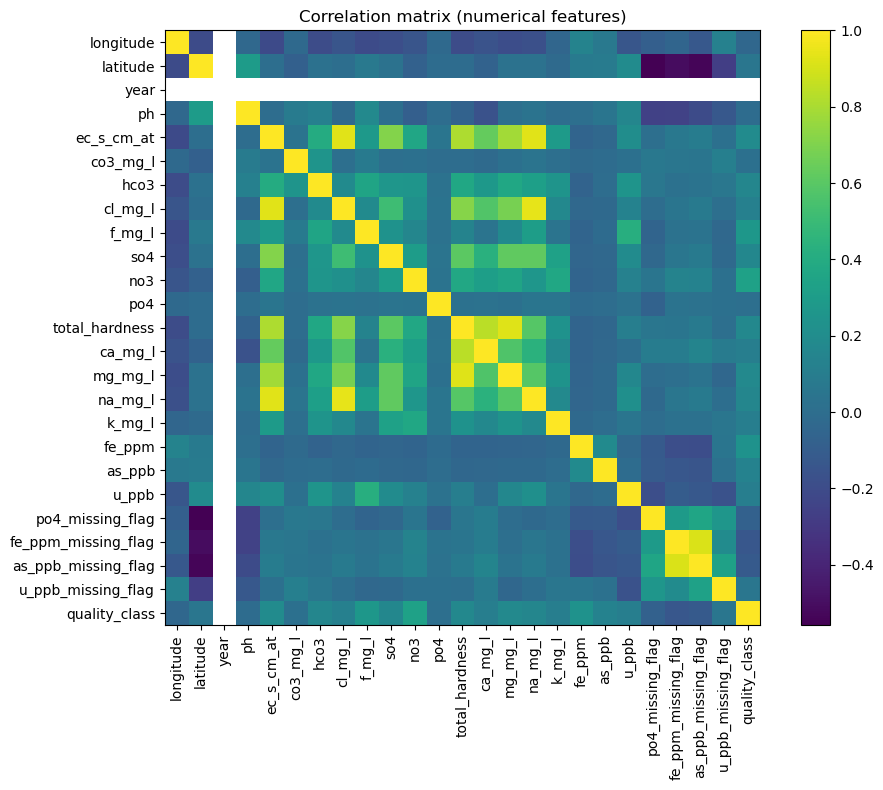

In [4]:
# Correlation of numeric features
num_df = df.select_dtypes(include=[np.number]).copy()
# drop ID columns from correlation
drop_cols = ['s_no'] if 's_no' in num_df.columns else []
corr = num_df.drop(columns=drop_cols, errors='ignore').corr()

# Plot a correlation heatmap with matplotlib (single plot)
plt.figure(figsize=(10,8))
plt.imshow(corr, interpolation='nearest')
plt.title('Correlation matrix (numerical features)')
plt.colorbar()
# ticks
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.tight_layout()
plt.show()

## Preprocessing
- Drop `s_no`, `location`.
- Encode `state` and `district` with LabelEncoder (keeps pipeline simple).
- Keep missingness flags.
- Scale numeric features (StandardScaler) — scaling applied inside pipeline for correct CV behavior.

In [5]:
# Preprocessing: drop and separate features
df_proc = df.copy()

# Drop identifier columns if present
for col in ['s_no', 'location']:
    if col in df_proc.columns:
        df_proc = df_proc.drop(columns=[col])

# Define target and features
target = 'quality_class'
if target not in df_proc.columns:
    raise KeyError(f"Target column '{target}' not found in data.")

X = df_proc.drop(columns=[target])
y = df_proc[target].astype(int)

# Identify categorical columns we want to encode
categorical_cols = [c for c in ['state','district'] if c in X.columns]
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
# ensure categorical not in numeric list
numeric_cols = [c for c in numeric_cols if c not in categorical_cols]

print('Categorical columns:', categorical_cols)
print('Numeric columns count:', len(numeric_cols))

Categorical columns: ['state', 'district']
Numeric columns count: 24


### Pipeline (ColumnTransformer)
- Numeric: impute (median) then scale
- Categorical: Label encode using a simple approach (LabelEncoder applied outside ColumnTransformer per-column)

**Note:** KNN requires scaled features.

In [6]:
# Simple label encoding for categorical columns (fit on full X to keep simple; we will save encoders)
label_encoders = {}
for c in categorical_cols:
    le = LabelEncoder()
    X[c] = X[c].astype(str).fillna('missing')
    X[c] = le.fit_transform(X[c])
    label_encoders[c] = le

# Numeric transformer using pipeline (imputer + scaler)
from sklearn.pipeline import make_pipeline
numeric_transformer = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

# Apply numeric transformer to numeric columns now (we will also scale via pipeline during CV to be robust)
X_num = numeric_transformer.fit_transform(X[numeric_cols])
X_num = pd.DataFrame(X_num, columns=numeric_cols, index=X.index)

# Replace numeric columns with transformed
X_transformed = X.copy()
X_transformed[numeric_cols] = X_num

print('Transformed X shape:', X_transformed.shape)

# Save encoders and transformer
import os
os.makedirs('/mnt/data/artifacts', exist_ok=True)
joblib.dump(label_encoders, '/mnt/data/artifacts/label_encoders.joblib')
joblib.dump(numeric_transformer, '/mnt/data/artifacts/numeric_transformer.joblib')
print('Saved encoders and numeric transformer to /mnt/data/artifacts')

Transformed X shape: (16737, 26)
Saved encoders and numeric transformer to /mnt/data/artifacts


## Train-test split and KNN modeling
- We'll split 80/20 stratified by target.
- Use a pipeline with StandardScaler + KNeighborsClassifier for correct handling.

In [7]:
# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42, stratify=y)
print('Train size:', X_train.shape)
print('Test size:', X_test.shape)

Train size: (13389, 26)
Test size: (3348, 26)


In [8]:
# Baseline KNN model with n_neighbors=5
pipeline = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=5))])

start = time.time()
pipeline.fit(X_train, y_train)
train_time = time.time() - start

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:,1] if hasattr(pipeline.named_steps['knn'], 'predict_proba') else None

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc_score = roc_auc_score(y_test, y_prob) if y_prob is not None else None

print('KNN (n=5) results:')
print(f'  Accuracy: {acc:.4f}')
print(f'  Precision: {prec:.4f}')
print(f'  Recall: {rec:.4f}')
print(f'  F1-score: {f1:.4f}')
print(f'  ROC-AUC: {auc_score if auc_score is None else f"{auc_score:.4f}"}')
print(f'  Training time (s): {train_time:.3f}')

print('\nClassification report:\n', classification_report(y_test, y_pred))

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNN (n=5) results:
  Accuracy: 0.8611
  Precision: 0.8790
  Recall: 0.7095
  F1-score: 0.7852
  ROC-AUC: 0.9284
  Training time (s): 0.017

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.95      0.90      2150
           1       0.88      0.71      0.79      1198

    accuracy                           0.86      3348
   macro avg       0.87      0.83      0.84      3348
weighted avg       0.86      0.86      0.86      3348



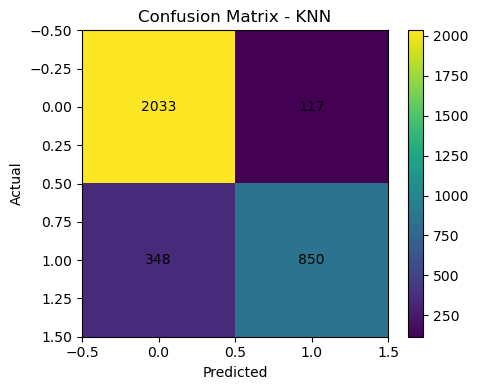

In [9]:
# Confusion matrix plot (matplotlib)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix - KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, str(val), ha='center', va='center')
plt.colorbar()
plt.tight_layout()
plt.show()

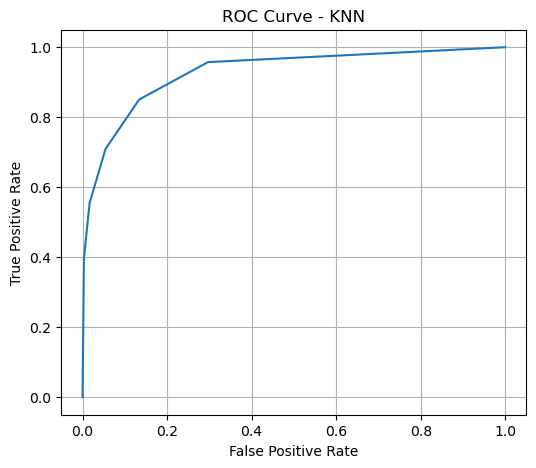

In [10]:
# ROC Curve (if probabilities available)
if y_prob is not None:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr)
    plt.title('ROC Curve - KNN')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()
else:
    print('Predict_proba not available for this KNN configuration')

## Cross-validation (Stratified K-Fold)
Compute CV accuracy and its standard deviation.

In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_transformed, y, cv=cv, scoring='accuracy', n_jobs=-1)
print('CV accuracy scores:', cv_scores)
print('Mean CV accuracy: %.4f ± %.4f' % (cv_scores.mean(), cv_scores.std()))

CV accuracy scores: [0.86499403 0.87037037 0.86136839 0.85210636 0.86017329]
Mean CV accuracy: 0.8618 ± 0.0060


## Hyperparameter tuning (GridSearchCV)
Tune `n_neighbors` and `weights`.

In [12]:
param_grid = {
    'knn__n_neighbors': [3,5,7,9,11],
    'knn__weights': ['uniform','distance']
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
start = time.time()
grid.fit(X_train, y_train)
grid_time = time.time() - start

print('Best params:', grid.best_params_)
print('Best CV score:', grid.best_score_)
print('Grid search time (s):', grid_time)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'knn__n_neighbors': 5, 'knn__weights': 'distance'}
Best CV score: 0.8669804433138987
Grid search time (s): 13.30199408531189


In [13]:
# Evaluate best model on test set
best = grid.best_estimator_
y_pred_best = best.predict(X_test)
y_prob_best = best.predict_proba(X_test)[:,1] if hasattr(best.named_steps['knn'], 'predict_proba') else None

print('Performance of best model on test:')
print('Accuracy:', accuracy_score(y_test, y_pred_best))
print('Precision:', precision_score(y_test, y_pred_best, zero_division=0))
print('Recall:', recall_score(y_test, y_pred_best, zero_division=0))
print('F1:', f1_score(y_test, y_pred_best, zero_division=0))
if y_prob_best is not None:
    print('ROC-AUC:', roc_auc_score(y_test, y_prob_best))

Performance of best model on test:
Accuracy: 0.8635005973715651
Precision: 0.88
Recall: 0.7161936560934892
F1: 0.7896916705016107
ROC-AUC: 0.9331715650114532


In [14]:
# Save the best model pipeline
os.makedirs('/mnt/data/models', exist_ok=True)
joblib.dump(best, '/mnt/data/models/knn_best_pipeline.joblib')
print('Saved best model to /mnt/data/models/knn_best_pipeline.joblib')

Saved best model to /mnt/data/models/knn_best_pipeline.joblib


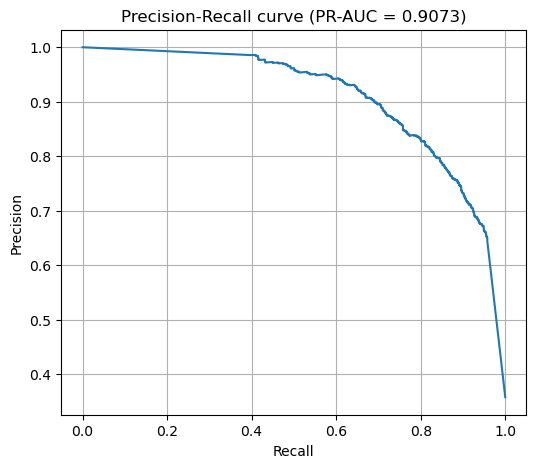

In [15]:
# Precision-Recall curve (if probabilities available)
if y_prob_best is not None:
    precision, recall, _ = precision_recall_curve(y_test, y_prob_best)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision)
    plt.title(f'Precision-Recall curve (PR-AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.show()
else:
    print('Probabilities not available - PR curve cannot be plotted')